<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN3150 Assignment 03

Team Name : Nova

### Setup Environment

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

if device.type == 'cuda':
    print('CUDA device name:', torch.cuda.get_device_name(0))

Device: cuda
CUDA device name: Tesla T4


In [2]:
import os
import json
from PIL import Image
import random
import shutil
from math import floor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary

import time
from torchvision import datasets, transforms, models
import copy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score
from tqdm import tqdm


### Download Dataset

In [7]:
!git clone https://github.com/sam-single/realwaste.git

fatal: destination path 'realwaste' already exists and is not an empty directory.


In [8]:
import os
current_dir = os.getcwd()

dataset_path = f'{current_dir}/realwaste/RealWaste'

### Load and split the dataset

Here we used the [RealWaste](https://archive.ics.uci.edu/dataset/908/realwaste) from UCI Machine Learning Repository.

In [9]:
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [10]:
# Remove existing split directories if they exist
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Create output directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Set random seed for reproducibility
random.seed(42)

# Split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create class subfolders inside each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image files
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    random.shuffle(images)

    total = len(images)
    train_end = floor(total * train_ratio)
    val_end = floor(total * (train_ratio + val_ratio))

    # Split lists
    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy files to respective folders
    for file_list, dest_dir in [
        (train_files, os.path.join(train_dir, class_name)),
        (val_files, os.path.join(val_dir, class_name)),
        (test_files, os.path.join(test_dir, class_name))
    ]:
        for filename in file_list:
            src = os.path.join(class_path, filename)
            dst = os.path.join(dest_dir, filename)
            shutil.copy2(src, dst)

    print(f"{class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\nDataset successfully split into train/val/test folders!")

Cardboard: 322 train, 69 val, 70 test
Miscellaneous Trash: 346 train, 74 val, 75 test
Vegetation: 305 train, 65 val, 66 test
Textile Trash: 222 train, 48 val, 48 test
Food Organics: 287 train, 62 val, 62 test
Plastic: 644 train, 138 val, 139 test
Glass: 294 train, 63 val, 63 test
Paper: 350 train, 75 val, 75 test
Metal: 553 train, 118 val, 119 test

Dataset successfully split into train/val/test folders!


### Offline Data Augmentation

After splitting the dataset into train, validation, and test sets, the number of images per class is imbalanced. To address this, we preprocess the training data by applying data augmentation techniques to increase the number of samples in underrepresented classes. This helps create a more balanced training set, improving the model's ability to learn and generalize across all classes.

In [11]:
# The number of images you want per class after augmentation
target_per_class = 600

In [12]:
# augmentation pipeline for saving (applied to PIL images)
save_aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # crop & resize
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((128,128)),
])

def make_augmented_images_for_class(class_train_dir, target_count, transforms, seed=42):
    """
    class_train_dir: e.g. "dataset_split/train/Cardboard"
    target_count: desired total images in this folder (including originals)
    transforms: torchvision transforms (expects PIL input)
    """
    random.seed(seed)
    existing_files = [f for f in os.listdir(class_train_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    current = len(existing_files)
    if current >= target_count:
        print(f"{os.path.basename(class_train_dir)} already has {current} >= {target_count}. Skipping.")
        return

    # make an 'aug' subfolder or just save into same folder with suffix
    idx = 0
    pbar = tqdm(total=(target_count - current), desc=f"Augment {os.path.basename(class_train_dir)}")
    # cycle over existing images and create variations
    existing_files_without_aug = [f for f in os.listdir(class_train_dir) if f.lower().endswith(('.jpg','.jpeg','.png')) and f.lower().startswith('aug_')==False]

    while current < target_count:
        src_fname = random.choice(existing_files_without_aug)
        src_path = os.path.join(class_train_dir, src_fname)
        try:
            img = Image.open(src_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {src_path}: {e}")
            continue

        aug_img = transforms(img)  # returns PIL or tensor depending on transforms; ensure PIL -> PIL
        # If transforms return a tensor, convert back to PIL before saving:
        if isinstance(aug_img, torch.Tensor):
            aug_img = transforms.ToPILImage()(aug_img)

        # create unique filename
        new_fname = f"aug_{idx:05d}__{src_fname}"
        new_path = os.path.join(class_train_dir, new_fname)
        if os.path.exists(new_path):
            continue  # avoid overwriting
        aug_img.save(new_path, quality=95)
        idx += 1
        current += 1
        pbar.update(1)

    pbar.close()
    print(f"Finished {os.path.basename(class_train_dir)}: now {current} images.")


train_root = train_dir

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)
    if not os.path.isdir(class_dir):
        continue
    make_augmented_images_for_class(class_dir, target_per_class, save_aug_transforms)


Augment Cardboard: 100%|██████████| 278/278 [00:01<00:00, 183.34it/s]


Finished Cardboard: now 600 images.


Augment Miscellaneous Trash: 100%|██████████| 254/254 [00:01<00:00, 178.37it/s]


Finished Miscellaneous Trash: now 600 images.


Augment Vegetation: 100%|██████████| 295/295 [00:02<00:00, 112.06it/s]


Finished Vegetation: now 600 images.


Augment Textile Trash: 100%|██████████| 378/378 [00:02<00:00, 159.43it/s]


Finished Textile Trash: now 600 images.


Augment Food Organics: 100%|██████████| 313/313 [00:01<00:00, 169.66it/s]


Finished Food Organics: now 600 images.
Plastic already has 644 >= 600. Skipping.


Augment Glass: 100%|██████████| 306/306 [00:01<00:00, 191.09it/s]


Finished Glass: now 600 images.


Augment Paper: 100%|██████████| 250/250 [00:01<00:00, 184.91it/s]


Finished Paper: now 600 images.


Augment Metal: 100%|██████████| 47/47 [00:00<00:00, 186.23it/s]

Finished Metal: now 600 images.


## Preprocessing Functions

In [13]:
import pandas as pd

def visualize_data(train_loader, classes):
    # Get one batch from train_loader
    X_batch, y_batch = next(iter(train_loader))

    W_grid, L_grid = 5,5
    fig, axes = plt.subplots(L_grid, W_grid, figsize=(12,12))
    axes = axes.ravel()

    for i in range(W_grid*L_grid):
        img = X_batch[i].permute(1,2,0).numpy()   # C,H,W → H,W,C
        img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(classes[y_batch[i]], fontsize=8)
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.4)
    plt.show()

def plot_dist(val_dir, test_dir):
    val_counts   = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in classes}
    test_counts  = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

    df_val   = pd.DataFrame(list(val_counts.items()), columns=['Class','Count'])
    df_test  = pd.DataFrame(list(test_counts.items()), columns=['Class','Count'])

    # Combine dataframes for plotting
    df_combined = pd.merge(df_val, df_test, on='Class', suffixes=('_Val', '_Test'))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(df_combined['Class']))

    bar1 = ax.bar(index, df_combined['Count_Val'], bar_width, label='Validation')
    bar2 = ax.bar(index + bar_width, df_combined['Count_Test'], bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Validation and Test Set Class Distribution')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df_combined['Class'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()


def load_and_preprocess_data(
    train_dir, val_dir, test_dir, batch_size, img_size,
    ):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # standard normalize with parameters from imagenet
    ])
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

    cpu_count = os.cpu_count() or 4
    num_workers = cpu_count // 2
    print("num_workers:", num_workers)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  prefetch_factor=2, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers, pin_memory=True, persistent_workers=True)

    classes = train_dataset.classes
    num_classes = len(classes)

    return train_loader, val_loader, test_loader, classes, num_classes, train_dataset, val_dataset, test_dataset

# Quick throughput check (small sample) to confirm speed-up
def bench_loader(loader, batches=10):
    t0 = time.time()
    it = iter(loader)
    for i in range(batches):
        try:
            _ = next(it)
        except StopIteration:
            break
    t1 = time.time()
    avg = (t1 - t0) / max(1, i+1)
    print(f"Bench: {i+1} batches in {t1-t0:.2f}s (avg {avg:.3f}s/batch)")

## Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):

    def __init__(self,
                 num_classes=9,
                 input_channels=3,
                 start_channels=64,
                 num_pooling_blocks=4, # e.g., 3 blocks -> H/8
                 dropout_conv=0.1,
                 dropout_fc=0.2):

        super().__init__()

        layers = []
        c_in = input_channels
        c_out = start_channels

        # Create the blocks with pooling
        for _ in range(num_pooling_blocks):
            layers.extend([
                # VGG-style block: (Conv-BN-ReLU) x 2
                nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),

                # Pool + Dropout
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(dropout_conv)
            ])
            c_in = c_out
            c_out *= 2 # Double channels for the next block

        # Final block
        c_out = c_out // 2 # Correction for the last c_out *= 2

        layers.extend([
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_conv)
        ])

        self.features = nn.Sequential(*layers)

        # --- 2. Build the Global Average Pooling Classifier ---

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # The classifier head
        self.classifier = nn.Sequential(
            nn.Linear(c_out, 128), # c_out is the final channel count
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_fc),
            nn.Linear(128, num_classes)
        )

        # --- 3. Initialize Weights ---
        self._init_weights()

    def _init_weights(self):
        # Kaiming init for convs and linear
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1) # a=1 is same as nonlinearity='leaky_relu' with slope 1
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 1. Get features
        x = self.features(x)  # (B, C_final, H_final, W_final)

        # 2. Pool
        x = self.gap(x)       # (B, C_final, 1, 1)

        # 3. Flatten
        x = torch.flatten(x, 1) # (B, C_final)

        # 4. Classify
        x = self.classifier(x)  # (B, num_classes)

        return x

### Training the Model

In [16]:
# ---------- History dict ----------
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [],  'val_acc': [],
    'train_prec': [], 'val_prec': [],
    'train_rec': [],  'val_rec': []
}

# ---------- helper functions ----------
def save_history(history, path):
    """Save history dict to JSON (converts numpy types to floats)."""
    serial = {}
    for k, v in history.items():
        # ensure it's a list of plain Python floats/ints
        serial[k] = [float(x) for x in v]
    with open(path, 'w') as f:
        json.dump(serial, f, indent=2)

def load_history(path, default=None):
    """Load history JSON if exists, else return default history."""
    if default is None:
        default = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [],  'val_acc': [],
            'train_prec': [], 'val_prec': [],
            'train_rec': [],  'val_rec': []
        }
    if os.path.exists(path):
        with open(path, 'r') as f:
            loaded = json.load(f)
        # ensure all keys exist and are lists
        for k in default:
            if k not in loaded:
                loaded[k] = []
        return loaded
    return default

def align_history_and_ckpt(history, ckpt_epoch):
    """
    Align history length with checkpoint epoch if possible.
    ckpt_epoch = last saved epoch in checkpoint (int) or None
    Returns (history, start_epoch)
    """
    # find min length among history lists
    lengths = [len(v) for v in history.values()]
    min_len = min(lengths) if lengths else 0
    # truncate all lists to same min_len (defensive)
    for k in list(history.keys()):
        history[k] = history[k][:min_len]

    # determine start epoch
    if ckpt_epoch is not None:
        # if history length is <= ckpt_epoch, we resume from ckpt_epoch+1
        start_epoch = ckpt_epoch + 1
        # if history already longer than ckpt_epoch+1, prefer history length
        if min_len > start_epoch:
            start_epoch = min_len
    else:
        start_epoch = min_len
    return history, start_epoch

In [59]:

# ---------- Helper: load checkpoint if exists ----------
def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Loads checkpoint if it exists and returns model, optimizer, start_epoch, best_val_loss."""
    start_epoch = 0
    best_val_loss = float('inf')
    optimizer_state_loaded = False # Track if optimizer state was loaded

    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
            model.load_state_dict(ckpt['model_state_dict'])
            if 'optimizer_state_dict' in ckpt:
                try:
                    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                    optimizer_state_loaded = True
                except Exception as e:
                    print("Warning: couldn't load optimizer state:", e)
            start_epoch = ckpt.get('epoch', 0) + 1 # Resume from next epoch
            best_val_loss = ckpt.get('best_val_loss', float('inf'))
            print(f"Loaded checkpoint (epoch {start_epoch-1}). Best val loss: {best_val_loss:.4f}")
        else:
            # assume this is a state_dict-only file
            model.load_state_dict(ckpt)
            print("Loaded model.state_dict() from checkpoint (no epoch stored).")
    else:
        print("No checkpoint found; starting fresh.")

    return model, optimizer, start_epoch, best_val_loss, optimizer_state_loaded


# ---------- Helper functions for training steps ----------
def train_step(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    train_preds = []
    train_targets = []
    for images, labels in tqdm(loader, desc=f"Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())
    train_loss = running_loss / len(train_targets)
    train_acc = np.mean(np.array(train_preds) == np.array(train_targets))
    train_prec = precision_score(train_targets, train_preds, average='macro', zero_division=0)
    train_rec = recall_score(train_targets, train_preds, average='macro', zero_division=0)
    return train_loss, train_acc, train_prec, train_rec

def val_step(model, loader, criterion, device):
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.detach().cpu().numpy())
            val_targets.extend(labels.detach().cpu().numpy())
    val_loss = val_running_loss / len(val_targets)
    val_acc = np.mean(np.array(val_preds) == np.array(val_targets))
    val_prec = precision_score(val_targets, val_preds, average='macro', zero_division=0)
    val_rec = recall_score(val_targets, val_preds, average='macro', zero_division=0)
    return val_loss, val_acc, val_prec, val_rec

# ---------- Training Loop ----------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, history, checkpoint_path, history_path, start_epoch, best_val_loss):
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        # ----- Training -----
        train_loss, train_acc, train_prec, train_rec = train_step(model, train_loader, optimizer, criterion, device)

        # ----- Validation -----
        val_loss, val_acc, val_prec, val_rec = val_step(model, val_loader, criterion, device)

        # store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)
        history['train_rec'].append(train_rec)
        history['val_rec'].append(val_rec)

        # Save history every epoch
        save_history(history, history_path)

        # print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ----- Checkpointing -----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # save full checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, checkpoint_path)

            save_history(history, history_path)

            print(f"  Saved improved checkpoint to {checkpoint_path}")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epochs")


### Test the Predictions of the Model

In [60]:
def load_best_model_for_evaluation(model, checkpoint_path, device):
    """Loads the best model from the checkpoint for evaluation."""
    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
            model.load_state_dict(ckpt['model_state_dict'])
            print("Loaded best model from checkpoint for evaluation.")
        else:
            model.load_state_dict(ckpt)
            print("Loaded model.state_dict() from checkpoint for evaluation.")
    else:
        print("No checkpoint found for evaluation.")
    return model

### Grid Visualization of Test Predictions

In [61]:
def plot_test_predictions_grid(model, test_dataset, classes, device, W_grid=5, L_grid=5):
    """
    Visualizes a grid of test predictions with true and predicted labels.
    """
    fig, axes = plt.subplots(L_grid, W_grid, figsize=(15,15))
    axes = axes.ravel()

    model.eval()
    with torch.no_grad():
        for i in range(W_grid*L_grid):
            idx = random.randint(0, len(test_dataset)-1)
            img, true_label = test_dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)

            output = model(img_tensor)
            pred_label = torch.argmax(output, dim=1).item()

            img_display = img.permute(1,2,0).numpy()
            img_display = img_display * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            img_display = np.clip(img_display, 0, 1)

            axes[i].imshow(img_display)
            color = 'blue' if pred_label == true_label else 'red'
            axes[i].set_title(f"P: {classes[pred_label]}\nT: {classes[true_label]}", fontsize=8, color=color)
            axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Visualize a grid of test predictions
# plot_test_predictions_grid(model, test_dataset, classes, device)

### Model Evaluation

In [62]:
import seaborn as sns

# ---- Plot training history ----
def plot_history(history):
    plt.figure(figsize=(15, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Evolution')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()


def generate_report(y_true, y_pred, classes):
    """
    Computes and plots the confusion matrix and prints the classification report.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred, target_names=classes))

def evaluate_model_on_test(model, test_loader, criterion, classes, device):
    # ---- Evaluate model on test data ----
    model.eval()
    test_loss = 0.0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Compute metrics
    test_loss /= len(test_loader.dataset)
    test_acc = sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
    test_prec = precision_score(y_true, y_pred, average='macro')
    test_rec = recall_score(y_true, y_pred, average='macro')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Precision: {test_prec * 100:.2f}%")
    print(f"Test Recall: {test_rec * 100:.2f}%")

    # Confusion matrix and classification report
    generate_report(y_true, y_pred, classes)





In [63]:
def experiment(model_name, model, optimizer, num_epochs, checkpoint_path, history_path, train_loader, val_loader, test_loader, classes, num_classes, device):
    """
    Runs the training and evaluation pipeline for a given model, optimizer.
    """
    print(f"\n=== Running Experiment for {model_name} ===")

    # ---------- Load checkpoint if exists ----------
    model, optimizer, start_epoch, best_val_loss, optimizer_state_loaded = load_checkpoint(model, optimizer, checkpoint_path, device)

    # ---------- Load history ----------
    history = load_history(history_path)

    # align history and compute start_epoch
    history, start_epoch = align_history_and_ckpt(history, start_epoch - 1)
    print(f"Resuming from epoch: {start_epoch}. History length: {len(history['train_loss'])}")

    # criteria
    criterion = nn.CrossEntropyLoss()

    # ---------- Training Loop ----------
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, history, checkpoint_path, history_path, start_epoch, best_val_loss)

    print("\n--- Training Finished ---")

    # ---------- Plot training history ----------
    print("\n--- Plotting History ---")
    history = load_history(history_path) # Load the latest history after training
    plot_history(history)

    # ---------- Test the Predictions of the Model ----------
    print("\n--- Evaluating on Test Set ---")
    # Load the best model from the best checkpoint before evaluation
    model = load_best_model_for_evaluation(model, checkpoint_path, device)

    # Evaluate model on test data
    evaluate_model_on_test(model, test_loader, criterion, classes, device)

    torch.cuda.empty_cache()
    print("GPU memory released.")

    print("\n=== Experiment Finished ===")
    return model, history # Return the trained model and history for further analysis



## Training

In [64]:
# common hyperparameters
num_epochs = 20
batch_size = 128
img_size = 128

In [65]:
train_loader, val_loader, test_loader, classes, num_classes, train_dataset, val_dataset, test_dataset = load_and_preprocess_data(train_dir, val_dir, test_dir, batch_size, img_size)

# print quick dataset stats
print(f"num_classes: {num_classes}, batch_size: {batch_size}")
n_train = len(train_dataset)
print("Training samples", n_train)

num_workers: 1
num_classes: 9, batch_size: 128
Training samples 5444


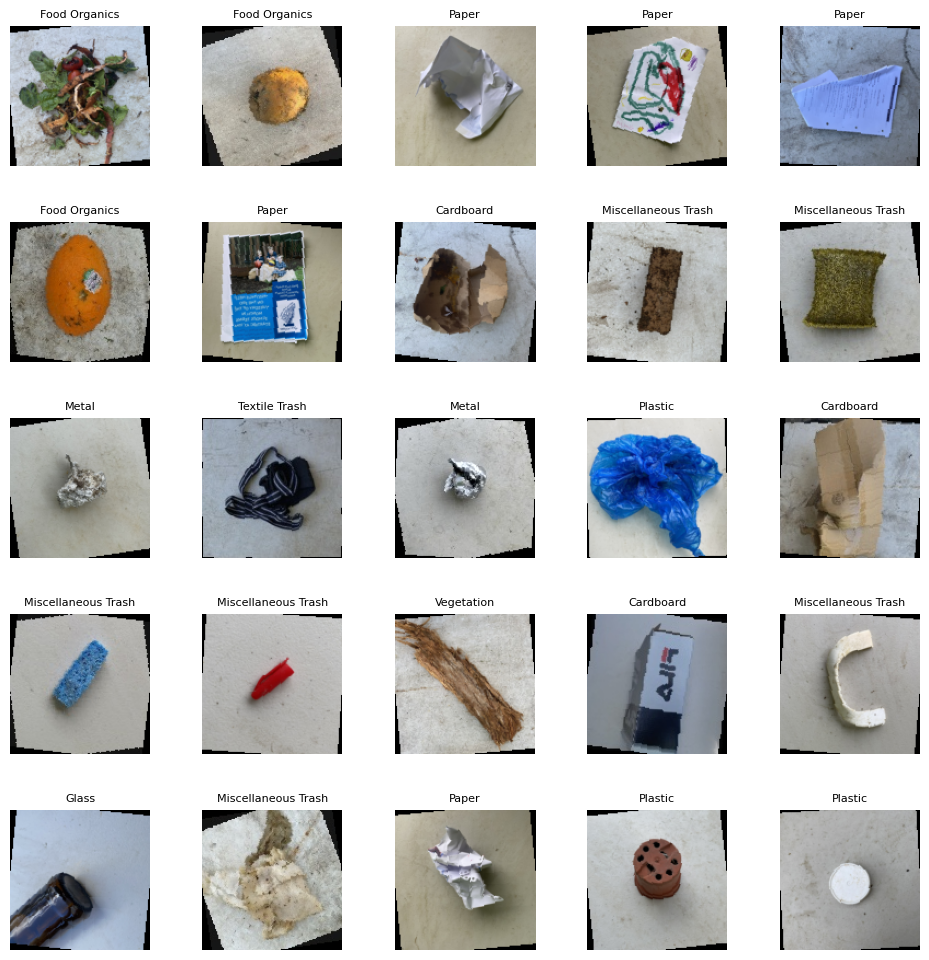

In [66]:
visualize_data(train_loader, classes)

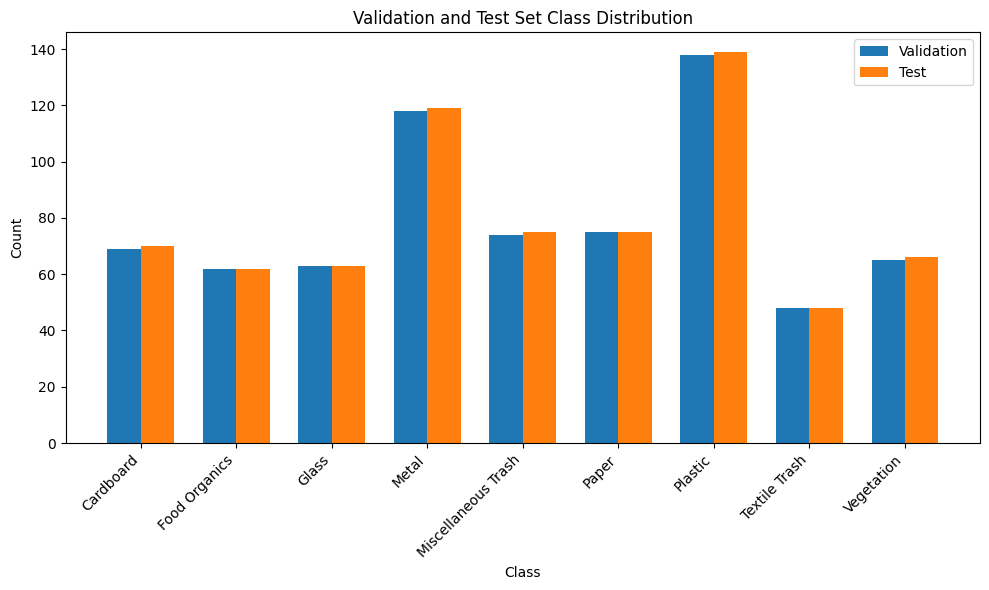

In [67]:
plot_dist(val_dir, test_dir)

In [68]:
# model
model = CNNModel(
    num_classes=num_classes,
    num_pooling_blocks=3,
    start_channels=32
).to(device)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
         Dropout2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,432
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## Training model with AdamW


=== Running Experiment for CNNModel_AdamW ===
Loaded checkpoint (epoch 18). Best val loss: 0.8165
Resuming from epoch: 20. History length: 20

--- Training Finished ---

--- Plotting History ---


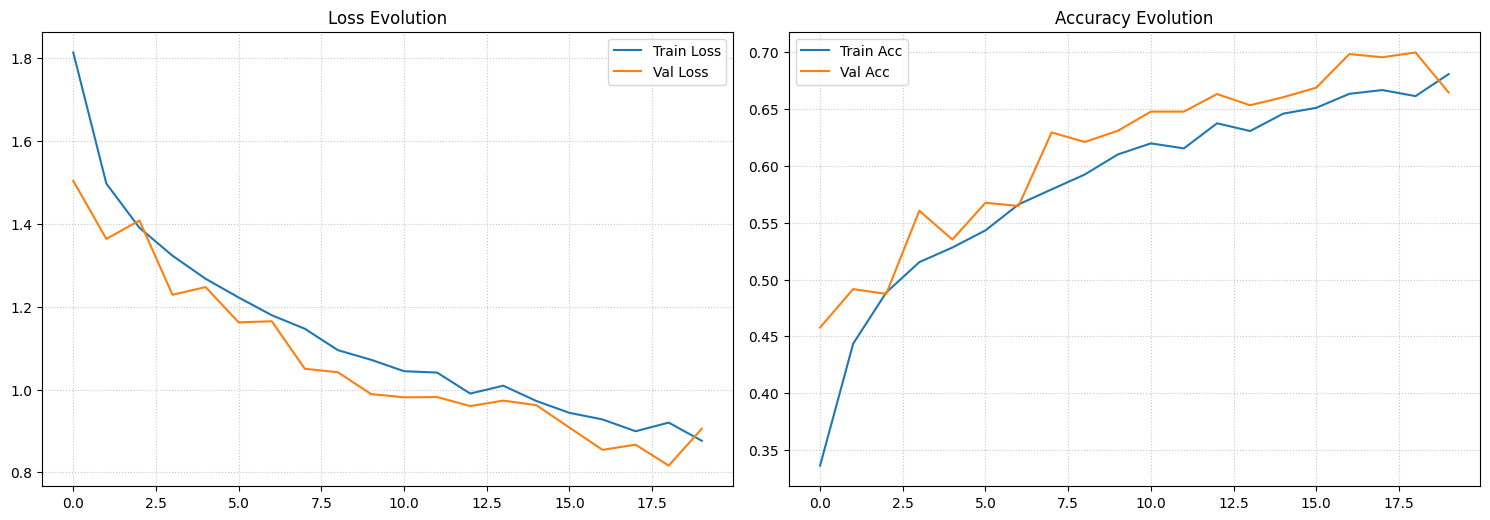


--- Evaluating on Test Set ---
Loaded best model from checkpoint for evaluation.
Test Loss: 0.7721
Test Accuracy: 69.74%
Test Precision: 70.35%
Test Recall: 71.03%


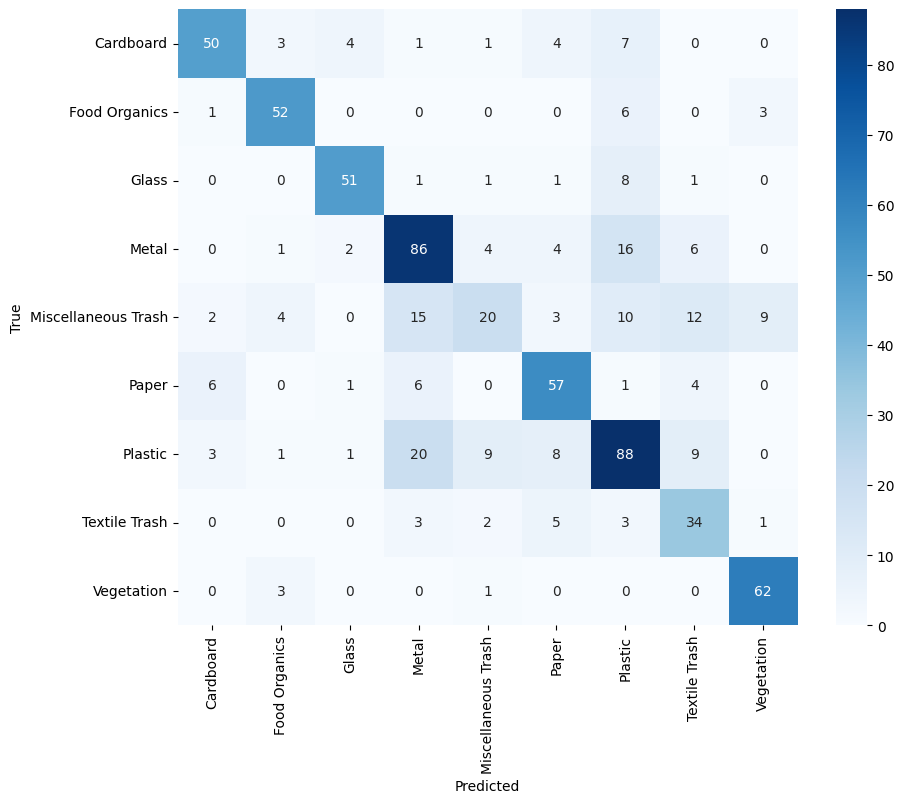

                     precision    recall  f1-score   support

          Cardboard       0.81      0.71      0.76        70
      Food Organics       0.81      0.84      0.83        62
              Glass       0.86      0.81      0.84        63
              Metal       0.65      0.72      0.69       119
Miscellaneous Trash       0.53      0.27      0.35        75
              Paper       0.70      0.76      0.73        75
            Plastic       0.63      0.63      0.63       139
      Textile Trash       0.52      0.71      0.60        48
         Vegetation       0.83      0.94      0.88        66

           accuracy                           0.70       717
          macro avg       0.70      0.71      0.70       717
       weighted avg       0.69      0.70      0.69       717

GPU memory released.

=== Experiment Finished ===


In [69]:
model_name = 'CNNModel_AdamW'
checkpoint_path = f'{model_name}_checkpoint.pth'
history_path = f'{model_name}_history.json'
learning_rate = 0.001
weight_decay = 1e-4

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

trained_model, training_history = experiment(
    model_name,
    model,
    optimizer,
    num_epochs,
    checkpoint_path,
    history_path,
    train_loader,
    val_loader,
    test_loader,
    classes,
    num_classes,
    device
)

## Training model with SGD


=== Running Experiment for CNNModel_SGD ===
Loaded checkpoint (epoch 13). Best val loss: 0.7834
Resuming from epoch: 20. History length: 20

--- Training Finished ---

--- Plotting History ---


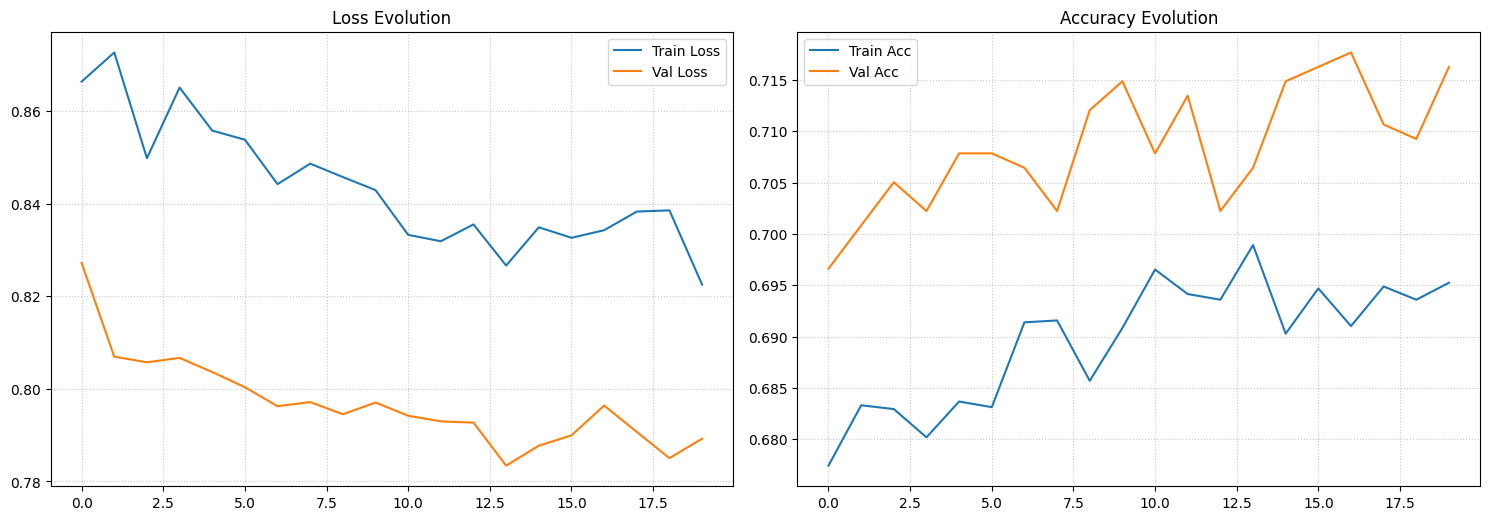


--- Evaluating on Test Set ---
Loaded best model from checkpoint for evaluation.
Test Loss: 0.7244
Test Accuracy: 72.80%
Test Precision: 74.58%
Test Recall: 72.65%


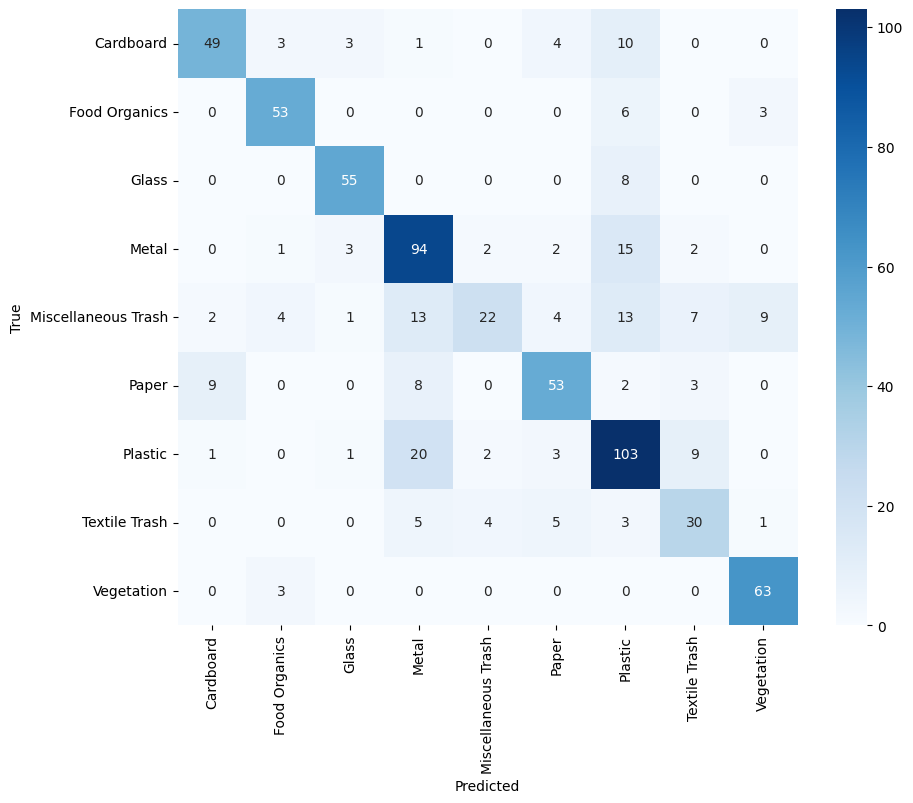

                     precision    recall  f1-score   support

          Cardboard       0.80      0.70      0.75        70
      Food Organics       0.83      0.85      0.84        62
              Glass       0.87      0.87      0.87        63
              Metal       0.67      0.79      0.72       119
Miscellaneous Trash       0.73      0.29      0.42        75
              Paper       0.75      0.71      0.73        75
            Plastic       0.64      0.74      0.69       139
      Textile Trash       0.59      0.62      0.61        48
         Vegetation       0.83      0.95      0.89        66

           accuracy                           0.73       717
          macro avg       0.75      0.73      0.72       717
       weighted avg       0.73      0.73      0.72       717

GPU memory released.

=== Experiment Finished ===


In [70]:
model_name = 'CNNModel_SGD'
checkpoint_path = f'{model_name}_checkpoint.pth'
history_path = f'{model_name}_history.json'
learning_rate = 0.001

# Define model, criterion, and optimizer outside the experiment function
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
)

trained_model, training_history = experiment(
    model_name,
    model,
    optimizer,
    num_epochs,
    checkpoint_path,
    history_path,
    train_loader,
    val_loader,
    test_loader,
    classes,
    num_classes,
    device
)

## Training model with SGD+ Momentum

In [ ]:
model_name = 'CNNModel_SGD_momentum'
checkpoint_path = f'{model_name}_checkpoint.pth'
history_path = f'{model_name}_history.json'
learning_rate = 0.001

# Define model, criterion, and optimizer outside the experiment function
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9
)

trained_model, training_history = experiment(
    model_name,
    model,
    optimizer,
    num_epochs,
    checkpoint_path,
    history_path,
    train_loader,
    val_loader,
    test_loader,
    classes,
    num_classes,
    device
)

# 2. Comparison of the network with state-of-the-art networks


We choose ResNet18 and DenseNet121 as the state-of-the-art networks

### Helper functions

In [ ]:
# --- 2_model_factory ---
# returns a pretrained model with final classifier replaced for num_classes.
def get_pretrained_model(name, num_classes, feature_extract=False):
    """
    name: 'resnet18' or 'densenet121'
    feature_extract: if True, freeze backbone and only train final classifier
    """
    name = name.lower()
    # load model with pretrained weights (compatibility try-except for torchvision versions)
    if name == 'resnet18':
        try:
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        classifier_params = model.fc.parameters()
    elif name == 'densenet121':
        try:
            model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        except Exception:
            model = models.densenet121(pretrained=True)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        classifier_params = model.classifier.parameters()
    else:
        raise ValueError("Unsupported model name")

    if feature_extract:
        # freeze all params except final classifier
        for param in model.parameters():
            param.requires_grad = False
        for p in classifier_params:
            p.requires_grad = True

    return model.to(device)



In [ ]:
# --- 3_training_helpers ---
# generic train/validate functions. records history dict with losses & accuracies per epoch.
from sklearn.metrics import precision_score, recall_score

def train_one_epoch(model, loader, optimizer, criterion, scaler=None, accum_steps=1):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels) / accum_steps
        if torch.cuda.is_available():
            scaler.scale(loss).backward()
        else:
            loss.backward()
        if (i + 1) % accum_steps == 0:
            if torch.cuda.is_available():
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        running_loss += float(loss.item()) * images.size(0) * accum_steps  # rescale back
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    train_loss = running_loss / len(targets)
    train_acc = np.mean(np.array(preds) == np.array(targets))
    train_prec = precision_score(targets, preds, average='macro', zero_division=0)
    train_rec = recall_score(targets, preds, average='macro', zero_division=0)
    return train_loss, train_acc, train_prec, train_rec

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)
        running_loss += float(loss.item()) * images.size(0)
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    val_loss = running_loss / len(targets)
    val_acc = np.mean(np.array(preds) == np.array(targets))
    val_prec = precision_score(targets, preds, average='macro', zero_division=0)
    val_rec = recall_score(targets, preds, average='macro', zero_division=0)
    return val_loss, val_acc, val_prec, val_rec

def evaluate_on_test(model, loader):
    model.eval()
    preds, targets = [], []
    device_type = device.type
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
                outputs = model(images)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # defensive: ensure lists not empty
    if len(targets) == 0:
        return "No test samples.", None

    # explicitly provide labels to avoid mismatch when some classes are missing
    label_list = list(range(num_classes))
    report = classification_report(targets, preds, labels=label_list, target_names=classes, zero_division=0)
    cm = confusion_matrix(targets, preds, labels=label_list)
    return report, cm

In [ ]:
# --- 4_train_finetune_function ---
# This function trains (fine-tunes) a given model name and returns the history & best model.
def run_finetune(name, feature_extract=False, epochs=12, batch_size_local=None, accum_steps=1, checkpoint_prefix='model'):
    """
    name: 'resnet18' or 'densenet121'
    feature_extract: if True freeze backbone (train only classifier)
    epochs: total epochs
    accum_steps: gradient accumulation steps to emulate larger batch
    """
    print(f"\n=== Training {name}  | feature_extract={feature_extract}  | epochs={epochs} ===")
    model = get_pretrained_model(name, num_classes=num_classes, feature_extract=feature_extract)

    # re-create optimizer for params that require grad
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
    # OneCycleLR: total_steps = epochs * steps_per_epoch
    steps_per_epoch = max(1, len(train_loader))
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=epochs * steps_per_epoch)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    device_type = device.type  # e.g. 'cuda' or 'cpu'
    scaler = torch.amp.GradScaler(device_type=device_type, enabled=(device_type == 'cuda'))


    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[],
               'train_prec':[], 'val_prec':[], 'train_rec':[], 'val_rec':[]}

    for epoch in range(epochs):
        t0 = time.time()
        # train (using accum steps)
        train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler, accum_steps=accum_steps)

        try:
            scheduler.step()
        except Exception:
            pass

        val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec); history['val_prec'].append(val_prec)
        history['train_rec'].append(train_rec); history['val_rec'].append(val_rec)

        epoch_time = time.time() - t0
        print(f"Epoch {epoch+1}/{epochs}  time={epoch_time:.1f}s  train_loss={train_loss:.4f} train_acc={train_acc:.4f}  val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
        # checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, f"{checkpoint_prefix}_{name}.pth")
            print("  saved best checkpoint")
    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history


### ResNet18

In [ ]:
# --- ResNet: 1_train_resnet18 ---

# Config — change these if you want a different mode
model_name = 'resnet18'
feature_extract = False   # True => freeze backbone and train only final layer (fast); False => fine-tune whole network
epochs = 12
checkpoint_path = f'best_{model_name}_{"feat" if feature_extract else "ft"}.pth'
history_path = f'history_{model_name}_{"feat" if feature_extract else "ft"}.json'

print("Device:", device)
# Build model (uses get_pretrained_model from earlier cell)
model = get_pretrained_model(model_name, num_classes=num_classes, feature_extract=feature_extract)
print("Model created:", model_name, "feature_extract=", feature_extract)

# optimizer & scheduler
params_to_update = [p for p in model.parameters() if p.requires_grad]
adam_optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
# basic LR scheduler, optional: change to OneCycleLR if you stepped per-batch
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', factor=0.5, patience=3)

criterion = nn.CrossEntropyLoss()
device_type = device.type  # e.g. 'cuda' or 'cpu'
scaler = torch.amp.GradScaler(enabled=(device_type == 'cuda'))

best_val_loss = float('inf')
best_wts = copy.deepcopy(model.state_dict())
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):
    t0 = time.time()
    train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, adam_optimizer, criterion, scaler=scaler, accum_steps=1)
    val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)
    scheduler.step(val_loss)  # reduce on plateau

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)

    print(f"[ResNet] Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}  time={time.time()-t0:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': adam_optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, checkpoint_path)
        print("  Saved improved checkpoint:", checkpoint_path)

# load best weights at end
model.load_state_dict(best_wts)
torch.save(model.state_dict(), checkpoint_path.replace('.pth', '_final_state.pth'))
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print("Finished training ResNet. Best val loss:", best_val_loss, "History saved to", history_path)


Device: cuda
Model created: resnet18 feature_extract= False
[ResNet] Epoch 1/12  train_loss=1.0508 train_acc=0.6379 | val_loss=2.8574 val_acc=0.3750  time=49.5s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 2/12  train_loss=0.6941 train_acc=0.7604 | val_loss=1.6518 val_acc=0.5000  time=53.5s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 3/12  train_loss=0.5256 train_acc=0.8171 | val_loss=0.8065 val_acc=0.7500  time=50.3s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 4/12  train_loss=0.4090 train_acc=0.8616 | val_loss=0.3956 val_acc=0.7500  time=53.3s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 5/12  train_loss=0.3193 train_acc=0.8860 | val_loss=0.2980 val_acc=0.8750  time=54.0s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 6/12  train_loss=0.2794 train_acc=0.9038 | val_loss=0.1404 val_acc=0.8750  time=54.1s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 7/12  train_loss=0.

Running validation on VAL set for ResNet...
VAL loss: 0.0315, VAL acc: 1.0000, VAL prec: 1.0000, VAL rec: 1.0000
Classification report (VAL):
                     precision    recall  f1-score   support

          Cardboard       0.86      0.72      0.79        69
      Food Organics       0.95      0.85      0.90        62
              Glass       0.85      0.71      0.78        63
              Metal       0.62      0.93      0.75       118
Miscellaneous Trash       0.78      0.61      0.68        74
              Paper       0.71      0.93      0.81        75
            Plastic       0.89      0.60      0.72       138
      Textile Trash       0.88      0.75      0.81        48
         Vegetation       0.81      0.98      0.89        65

           accuracy                           0.78       712
          macro avg       0.82      0.79      0.79       712
       weighted avg       0.81      0.78      0.78       712



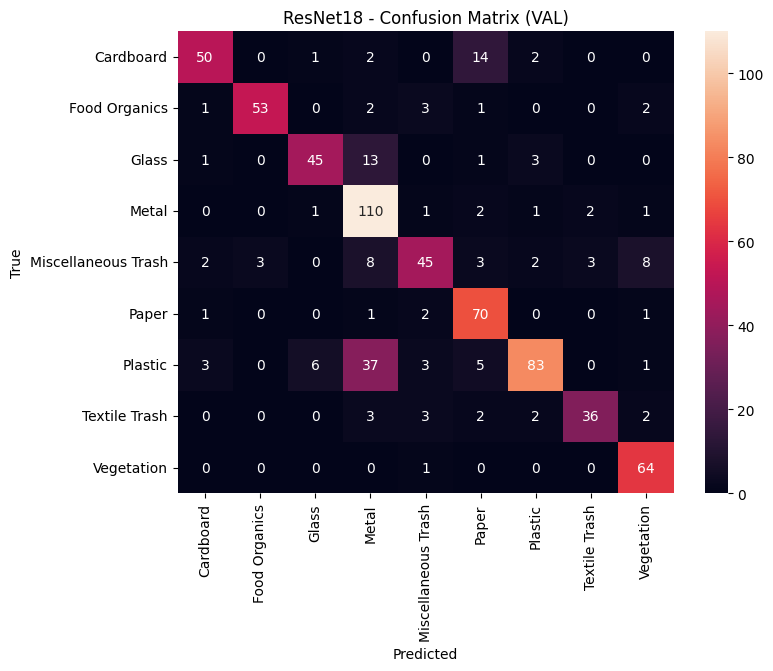

In [ ]:
# --- ResNet: 2_validate_resnet18_on_val ---

# Load best checkpoint if you want to evaluate the saved best model (optional)
ckpt = torch.load(f'best_resnet18_{"feat" if False else "ft"}.pth', map_location=device)  # adjust filename if feature_extract True
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

print("Running validation on VAL set for ResNet...")
val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, nn.CrossEntropyLoss())
print(f"VAL loss: {val_loss:.4f}, VAL acc: {val_acc:.4f}, VAL prec: {val_prec:.4f}, VAL rec: {val_rec:.4f}")

# Detailed per-class report & confusion matrix using evaluate_on_test-like function on val_loader
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("Classification report (VAL):")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("ResNet18 - Confusion Matrix (VAL)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Evaluating ResNet on TEST set...
Classification report (TEST):
                      precision    recall  f1-score   support

          Cardboard       0.78      0.60      0.68        70
      Food Organics       0.94      0.77      0.85        62
              Glass       0.87      0.76      0.81        63
              Metal       0.64      0.92      0.75       119
Miscellaneous Trash       0.71      0.73      0.72        75
              Paper       0.63      0.87      0.73        75
            Plastic       0.90      0.55      0.68       139
      Textile Trash       0.83      0.71      0.76        48
         Vegetation       0.81      0.97      0.88        66

           accuracy                           0.76       717
          macro avg       0.79      0.76      0.76       717
       weighted avg       0.78      0.76      0.75       717



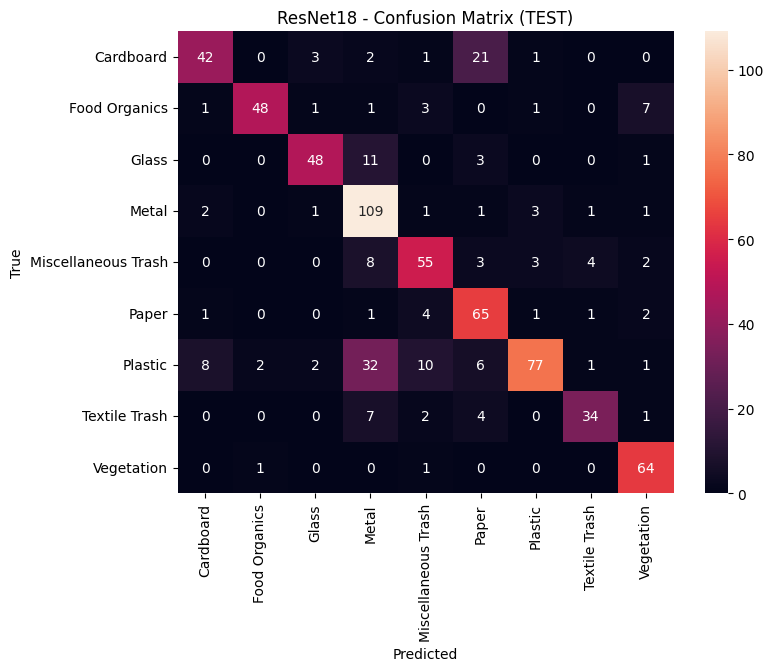

In [ ]:
# --- ResNet: 3_evaluate_resnet18_on_test ---

# Final evaluation on the TEST set for ResNet (classification report + confusion matrix)
print("Evaluating ResNet on TEST set...")
report, cm = evaluate_on_test(model, test_loader)   # uses helper evaluate_on_test defined earlier
print("Classification report (TEST):\n", report)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("ResNet18 - Confusion Matrix (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### DenseNet121

In [ ]:
# --- DenseNet: 4_train_densenet121 ---

model_name = 'densenet121'
feature_extract = False   # set True for just training classifier head (faster)
epochs = 12
checkpoint_path = f'best_{model_name}_{"feat" if feature_extract else "ft"}.pth'
history_path = f'history_{model_name}_{"feat" if feature_extract else "ft"}.json'

print("Device:", device)
model = get_pretrained_model(model_name, num_classes=num_classes, feature_extract=feature_extract)
print("Model created:", model_name, "feature_extract=", feature_extract)

params_to_update = [p for p in model.parameters() if p.requires_grad]
adam_optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', factor=0.5, patience=3)

criterion = nn.CrossEntropyLoss()
device_type = device.type  # e.g. 'cuda' or 'cpu'
scaler = torch.amp.GradScaler(enabled=(device_type == 'cuda'))


best_val_loss = float('inf')
best_wts = copy.deepcopy(model.state_dict())
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):
    t0 = time.time()
    train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, adam_optimizer, criterion, scaler=scaler, accum_steps=1)
    val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)

    print(f"[DenseNet] Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}  time={time.time()-t0:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': adam_optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, checkpoint_path)
        print("  Saved improved checkpoint:", checkpoint_path)

# load best weights and save history
model.load_state_dict(best_wts)
torch.save(model.state_dict(), checkpoint_path.replace('.pth', '_final_state.pth'))
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print("Finished training DenseNet. Best val loss:", best_val_loss, "History saved to", history_path)


Device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Induwara/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [02:16<00:00, 237kB/s] 


Model created: densenet121 feature_extract= False
[DenseNet] Epoch 1/12  train_loss=0.9105 train_acc=0.6812 | val_loss=0.9322 val_acc=0.6250  time=219.9s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 2/12  train_loss=0.5472 train_acc=0.8093 | val_loss=0.6464 val_acc=0.8750  time=132.7s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 3/12  train_loss=0.4034 train_acc=0.8591 | val_loss=1.4002 val_acc=0.5000  time=146.1s
[DenseNet] Epoch 4/12  train_loss=0.3287 train_acc=0.8882 | val_loss=0.3298 val_acc=0.8750  time=150.3s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 5/12  train_loss=0.2470 train_acc=0.9132 | val_loss=0.4315 val_acc=0.8750  time=151.9s
[DenseNet] Epoch 6/12  train_loss=0.2238 train_acc=0.9227 | val_loss=0.1510 val_acc=0.8750  time=140.9s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 7/12  train_loss=0.1992 train_acc=0.9320 | val_loss=0.8526 val_acc=0.8750  time=132.0s
[DenseNet]

Running validation on VAL set for DenseNet...
VAL loss: 0.0275, VAL acc: 1.0000, VAL prec: 1.0000, VAL rec: 1.0000
Classification report (VAL):
                     precision    recall  f1-score   support

          Cardboard       0.93      0.90      0.91        69
      Food Organics       0.87      0.97      0.92        62
              Glass       0.95      0.90      0.93        63
              Metal       0.87      0.86      0.87       118
Miscellaneous Trash       0.74      0.69      0.71        74
              Paper       0.94      0.89      0.92        75
            Plastic       0.83      0.88      0.86       138
      Textile Trash       0.89      0.88      0.88        48
         Vegetation       0.97      0.97      0.97        65

           accuracy                           0.88       712
          macro avg       0.89      0.88      0.88       712
       weighted avg       0.88      0.88      0.88       712



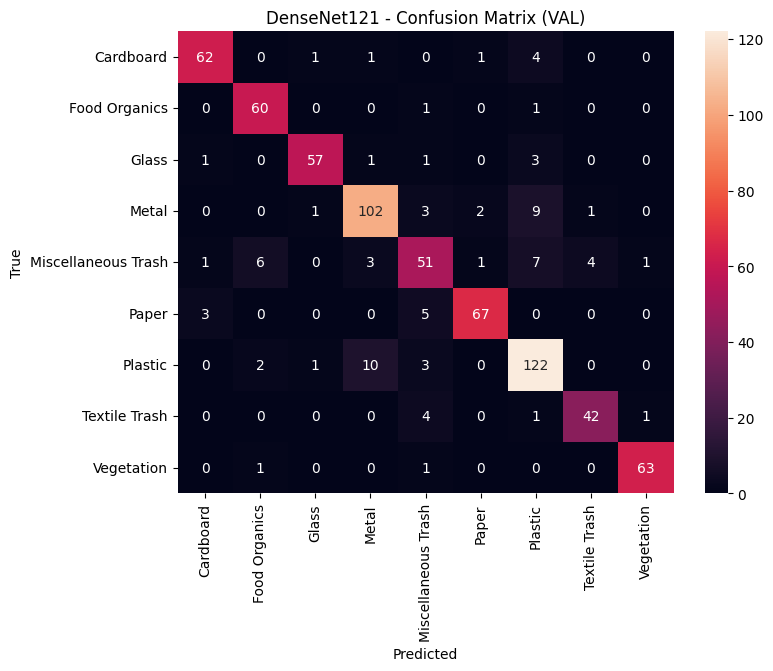

In [ ]:
# --- DenseNet: 5_validate_densenet121_on_val ---

# Load best checkpoint if desired
ckpt = torch.load(f'best_densenet121_{"feat" if False else "ft"}.pth', map_location=device)  # adjust if you trained feature_extract True
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

print("Running validation on VAL set for DenseNet...")
val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, nn.CrossEntropyLoss())
print(f"VAL loss: {val_loss:.4f}, VAL acc: {val_acc:.4f}, VAL prec: {val_prec:.4f}, VAL rec: {val_rec:.4f}")

y_true = []; y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(labels.cpu().numpy())

print("Classification report (VAL):")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("DenseNet121 - Confusion Matrix (VAL)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Evaluating DenseNet on TEST set...
Classification report (TEST):
                      precision    recall  f1-score   support

          Cardboard       0.94      0.97      0.96        70
      Food Organics       0.89      0.92      0.90        62
              Glass       0.91      0.97      0.94        63
              Metal       0.91      0.82      0.86       119
Miscellaneous Trash       0.87      0.79      0.83        75
              Paper       0.92      0.89      0.91        75
            Plastic       0.86      0.92      0.89       139
      Textile Trash       0.78      0.83      0.81        48
         Vegetation       0.94      0.95      0.95        66

           accuracy                           0.89       717
          macro avg       0.89      0.90      0.89       717
       weighted avg       0.89      0.89      0.89       717



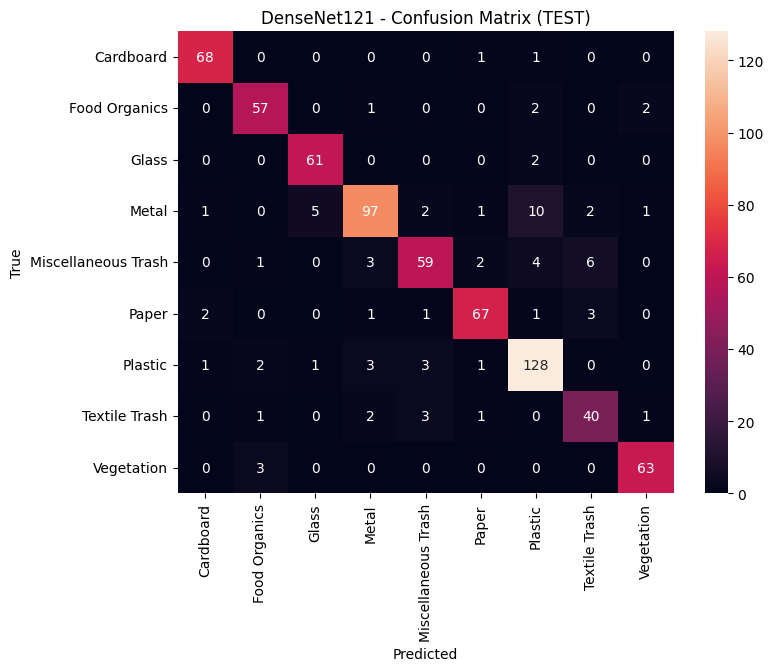

In [ ]:
# --- DenseNet: 6_evaluate_densenet121_on_test ---
print("Evaluating DenseNet on TEST set...")
report, cm = evaluate_on_test(model, test_loader)
print("Classification report (TEST):\n", report)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("DenseNet121 - Confusion Matrix (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### Final Evaluation and Comparison